# S2S RNN to predict next action from state

We aim to predict the next steps on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category
from Process_Training_Data_2 import extend_dataset
from Process_Training_Data_2 import normalize_data
from Process_Training_Data_2 import print_model_df_analysis
from Process_Training_Data_2 import group_by_path
from Process_Training_Data_2 import get_mean_error
from Process_Training_Data_2 import add_end_state

importing Jupyter notebook from Process_Training_Data_2.ipynb


### Get the data
First Import it using pandas

In [23]:
file = "OSPA_training_data.csv"

In [25]:
STEPS=8

dataset = Process_Training_Data_2.get_data("./data/"+file)

dataset_distances= dataset[["id_camino","D0",'D1',"D2","D3",'D4',"D5","A0","A1"]]

#exteneded_dataset = Process_Training_Data_2.extend_dataset(dataset_short,N_STEPS)
exteneded_dataset= add_end_state(dataset_distances)

action_vector = ["A0","A1"]
normed_dataset, data_stats = Process_Training_Data_2.normalize_data(exteneded_dataset, action_vector)

position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,STEPS,position)

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [12]:
def multivariate_data(dataset, target, start_index, end_index):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, len(dataset[i])-1)
    data.append(dataset[i,indices,:])

    labels.append(target[i, 1:])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [26]:
np.random.shuffle(dataset2)

In [27]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
features_dataset = dataset2[:,:,:6]
target_dataset = dataset2[:,:,6:8]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None)

In [28]:
x_train_single_sequential[0]

array([[ 2.14294786e+00, -1.91258837e+00, -8.90080735e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.95750753e+00, -1.72676472e+00, -1.46845955e+00,
        -1.25302847e+00,  1.48973366e+00,  9.80510522e-01],
       [ 1.68334149e+00, -1.14767565e+00, -2.47487772e+00,
        -6.42845599e-01,  2.16395006e+00,  3.85471651e-01],
       [ 1.25139924e+00, -4.95338757e-01, -2.92204027e+00,
        -1.86824775e+00,  7.06060616e-01, -1.40145001e+00],
       [ 7.47874689e-01, -4.44238727e-02, -2.97172961e+00,
        -6.86887925e-01,  1.15141305e+00,  3.88511556e-01],
       [ 2.32185380e-01,  1.85900755e-01, -2.65662682e+00,
        -1.85249317e+00, -3.21018880e-01, -1.15291520e+00],
       [ 7.49750227e-05,  8.41985208e-02, -2.21102112e+00,
        -1.78666740e+00, -8.70444744e-01, -7.61540015e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [29]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (8, 6)


In [31]:
y_train_single_sequential[8]

array([[-0.     ,  0.     ],
       [-0.     ,  0.     ],
       [-0.03491,  0.     ],
       [-0.     ,  0.     ],
       [-0.03491,  0.     ],
       [-0.03491,  0.     ],
       [ 0.     ,  0.     ],
       [ 0.     ,  0.     ]])

In [33]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

In [35]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True, input_shape=(None, 6)))
single_step_sequential_model.add(tf.keras.layers.Dense(2, activation='linear'))

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', metrics=['mse','mae'])

### Inspect the model

In [36]:
single_step_sequential_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 11)          792       
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           24        
Total params: 816
Trainable params: 816
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [37]:
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 192.0 steps, validate for 50 steps
Epoch 1/20
192/192 [==============================] - 16s 84ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0761 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0284
Epoch 2/20
192/192 [==============================] - 2s 11ms/step - loss: 9.9387e-04 - mse: 9.9387e-04 - mae: 0.0230 - val_loss: 5.8822e-04 - val_mse: 5.8822e-04 - val_mae: 0.0175
Epoch 3/20
192/192 [==============================] - 2s 10ms/step - loss: 6.2820e-04 - mse: 6.2820e-04 - mae: 0.0178 - val_loss: 4.5055e-04 - val_mse: 4.5055e-04 - val_mae: 0.0148
Epoch 4/20
192/192 [==============================] - 2s 10ms/step - loss: 5.1062e-04 - mse: 5.1062e-04 - mae: 0.0157 - val_loss: 3.9678e-04 - val_mse: 3.9678e-04 - val_mae: 0.0137
Epoch 5/20
192/192 [==============================] - 2s 9ms/step - loss: 4.5181e-04 - mse: 4.5181e-04 - mae: 0.0145 - val_loss: 3.6707e-04 - val_mse: 3.6707e-04 - val_mae: 0.0130
Epoch 6/20
192/192 [==============================] - 2s 10ms/step

Compute the accuracy

In [38]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [41]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,-1,:])) 
print(m.result().numpy())
m.reset_states()

0.5833333


In [42]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

48/48 - 0s - loss: 2.5682e-04 - mse: 2.5682e-04 - mae: 0.0098


Visualize the model's training progress.

In [43]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

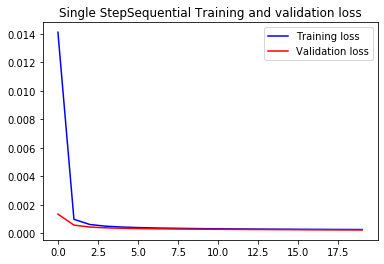

In [44]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

#### Adding early stop

In [45]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0003,  mae:0.0100,  mse:0.0003,  val_loss:0.0002,  val_mae:0.0095,  val_mse:0.0002,  
....................

In [47]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,-1,:])) 
print(m.result().numpy())
m.reset_states() 

0.5416667


In [49]:
single_step_sequential_model.save('./data/S2A_model.h5') 